In [1]:
import os, sys, pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder, get_flow_params

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ddpg import DDPGAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'
exp_name = 'latest'
results_list = os.listdir('/headless/ray_results/' + exp_name)
AGENT = 'PPO' # 'PPO' or 'DDPG' or 'HUMAN'
checkpoint = '50'
num_cpus = 60
num_trials = 50

benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.flow_params

ray.init(num_cpus=num_cpus, include_webui=False, ignore_reinit_error=True)

2019-05-30 03:59:29,421	INFO node.py:469 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-30_03-59-29_37655/logs.
2019-05-30 03:59:29,545	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:44514 to respond...
2019-05-30 03:59:29,694	INFO services.py:407 -- Waiting for redis server at 127.0.0.1:40036 to respond...
2019-05-30 03:59:29,699	INFO services.py:804 -- Starting Redis shard with 10.0 GB max memory.
2019-05-30 03:59:29,770	INFO node.py:483 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-30_03-59-29_37655/logs.
2019-05-30 03:59:29,774	INFO services.py:1427 -- Starting the Plasma object store with 18.23 GB memory using /dev/shm.


{'node_ip_address': '10.138.0.2',
 'object_store_address': '/tmp/ray/session_2019-05-30_03-59-29_37655/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-05-30_03-59-29_37655/sockets/raylet',
 'redis_address': '10.138.0.2:44514',
 'webui_url': None}

In [2]:
PPO_PATH = 'PPO_eta2:0.1_eta3:0.0_tmin:10.0_buflen:1_2_2019-05-30_01-08-56_abugxdn'

In [3]:
PATH = ''
if AGENT == 'PPO':
    PATH = exp_name + '/' + PPO_PATH
    
if AGENT == 'DDPG':
    PATH = exp_name + '/' + DDPG_PATH
    
config_path = '/headless/rl_project/ray_results/' + PATH + '/params.pkl'
checkpoint_path = '/headless/rl_project/ray_results/' + PATH + '/checkpoint_{}/checkpoint-{}'.format(checkpoint, checkpoint)

with open(config_path, mode='rb') as f:
    config = pickle.load(f)
flow_params = get_flow_params(config)
create_env, env_name = make_create_env(params=flow_params, version=0)
env = create_env()
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10

# Register as rllib env
register_env(env_name, create_env)

In [4]:
@ray.remote
def evaluate(create_env, AGENT, config=None, env_name=None, checkpoint_path=None):
    agent = None
    if AGENT == 'PPO':
        agent = PPOAgent(config=config, env=env_name)
        agent.restore(checkpoint_path)
        
    env = create_env()
    
    left_length = env.k.scenario.edge_length('left')
    car_length = 5.0
    scale = 10
    
    # test until horizon
    state = env.reset()
    vel = []
    outflow = []
    for i in range(env.env_params.horizon):
        # record the mean velocity
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        vel.append(v)

        # record the velocity map
        ids = env.k.vehicle.get_ids()
        vel_map_ = np.zeros(int(left_length)*scale)
        for id_ in ids:
            pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
            vel_ = env.k.vehicle.get_speed(id_)
            pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
            pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
            if env.k.vehicle.get_edge(id_) == 'left':
                vel_map_[pos_bottom:pos_top] = vel_            

        # step the simulation
        rl_ids = env.k.vehicle.get_rl_ids()
        actions = {}
        if AGENT != 'HUMAN':
            for id_ in rl_ids:
                action = agent.compute_action(state[id_])
                actions.update({id_: action})
        state, r, _, _ = env.step(actions)
        outflow.append(env.k.vehicle.get_outflow_rate(100)) # measured by one min

        if i == 0:
            vel_map_list = vel_map_
        else:
            vel_map_list = np.vstack((vel_map_list, vel_map_))

    outflow = outflow[-500:]
    vel_map_list[vel_map_list==0.0] = np.nan

    return vel, outflow, vel_map_list

In [5]:
%%time
results = ray.get([evaluate.remote(create_env, AGENT, config, env_name, checkpoint_path) for _ in range(num_trials)])

2019-05-30 03:59:32,114	WARNING worker.py:334 -- WARNING: Falling back to serializing objects of type <class 'numpy.dtype'> by using pickle. This may be inefficient.


(pid=37793) 2019-05-30 03:59:52,078	WARNING __init__.py:21 -- DeprecationWarning: PPOAgent has been renamed to PPOTrainer. This will raise an error in the future.
(pid=37793) 2019-05-30 03:59:52,104	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=37793) 2019-05-30 03:59:52,104	WARNING ppo.py:171 -- FYI: By default, the value function will not share layers with the policy model ('vf_share_layers': False).
(pid=37793) Loading configuration... done.
(pid=37793) Success.
(pid=37793) Loading configuration... done.
(pid=37829) 2019-05-30 03:59:52,712	WARNING __init__.py:21 -- DeprecationWarning: PPOAgent has been renamed to PPOTrainer. This will raise an error in the future.
(pid=37829) 2019-05-30 03:59:52,738	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if th

(pid=37818) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37818)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=37799) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37799)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=37805) 2019-05-30 03:59:54,884	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=37805) 2019-05-30 03:59:54.887518: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=37840) /o

(pid=37785) Loading configuration... done.
(pid=37792) Loading configuration... done.
(pid=37840) 2019-05-30 03:59:56,584	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7fde2b5a7860>}
(pid=37840) 2019-05-30 03:59:56,585	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fde2b5a7550>}
(pid=37840) 2019-05-30 03:59:56,585	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7fde2b5a72b0>}
(pid=37822) 2019-05-30 03:59:56,559	WARNING __init__.py:21 -- DeprecationWarning: PPOAgent has been renamed to PPOTrainer. This will raise an error in the future.
(pid=37822) 2019-05-30 03:59:56,583	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(p

(pid=37798) Loading configuration... done.
(pid=37798) Success.
(pid=37822) 2019-05-30 03:59:57,720	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=37784) 2019-05-30 03:59:57,687	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 8 on CPU (please ignore any CUDA init errors)
(pid=37784) 2019-05-30 03:59:57.689480: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=37791) Loading configuration... done.
(pid=37791) Success.
(pid=37822) 2019-05-30 03:59:57.723877: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=37834) Loading configuration... done.
(pid=37798) Loading configuration... done.
(pid=37834) Success.
(pid=37791) Loading configuration... done.
(pid=37833) 2019-05-30 03:59:57,736	IN

(pid=37811) Loading configuration... done.
(pid=37811) Success.
(pid=37826) Loading configuration... done.
(pid=37797) Loading configuration... done.
(pid=37838) Loading configuration... done.
(pid=37836) Loading configuration... done.
(pid=37782) Loading configuration... done.
(pid=37817) 2019-05-30 03:59:58,171	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=37817) 2019-05-30 03:59:58,171	WARNING ppo.py:171 -- FYI: By default, the value function will not share layers with the policy model ('vf_share_layers': False).
(pid=37830) 2019-05-30 03:59:58,177	WARNING __init__.py:21 -- DeprecationWarning: PPOAgent has been renamed to PPOTrainer. This will raise an error in the future.
(pid=37830) 2019-05-30 03:59:58,203	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=T

(pid=37831) 2019-05-30 03:59:58,659	WARNING __init__.py:21 -- DeprecationWarning: PPOAgent has been renamed to PPOTrainer. This will raise an error in the future.
(pid=37783) Loading configuration... done.
(pid=37827) 2019-05-30 03:59:58,652	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=37827) 2019-05-30 03:59:58.654173: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=37825) Loading configuration... done.
(pid=37801) 2019-05-30 03:59:58,685	WARNING __init__.py:21 -- DeprecationWarning: PPOAgent has been renamed to PPOTrainer. This will raise an error in the future.
(pid=37831) 2019-05-30 03:59:58,686	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=37831) 2019-05-30 03:59:58,6

(pid=37827) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37827)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=37837) Loading configuration... done.
(pid=37837) Success.
(pid=37782) 2019-05-30 03:59:59,178	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=37782) 2019-05-30 03:59:59.181356: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=37838) 2019-05-30 03:59:59,198	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=37786) 2019-05-30 03:59:59,151	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignor

(pid=37822) 2019-05-30 03:59:59,612	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7fce57a7d8d0>}
(pid=37822) 2019-05-30 03:59:59,612	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fce57a7d5c0>}
(pid=37822) 2019-05-30 03:59:59,612	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7fce57a7d320>}
(pid=37783) 2019-05-30 03:59:59,681	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=37783) 2019-05-30 03:59:59.683958: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=37821) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarni

(pid=37810) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37810)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=37825) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37825)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=37837) 2019-05-30 04:00:00,177	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
(pid=37837) 2019-05-30 04:00:00.180001: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=37795) /o

(pid=37837) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37837)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=37822) 2019-05-30 04:00:00,915	INFO multi_gpu_optimizer.py:78 -- LocalMultiGPUOptimizer devices ['/cpu:0']
(pid=37806) 2019-05-30 04:00:01,138	INFO multi_gpu_optimizer.py:78 -- LocalMultiGPUOptimizer devices ['/cpu:0']
(pid=37809) 2019-05-30 04:00:01,287	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7fdcb6a6f898>}
(pid=37809) 2019-05-30 04:00:01,287	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fdcb6a6f550>}
(pid=37809) 2019-05-30 04:00:01,287	INFO policy_evaluator.py:343 -- Built filter ma

(pid=37824) 2019-05-30 04:00:01,895	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7f5bf2f038d0>}
(pid=37824) 2019-05-30 04:00:01,896	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f5bf2f035c0>}
(pid=37824) 2019-05-30 04:00:01,896	INFO policy_evaluator.py:343 -- Built filter map: {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x7f5bf2f03320>}
(pid=37827) 2019-05-30 04:00:01,872	INFO multi_gpu_optimizer.py:78 -- LocalMultiGPUOptimizer devices ['/cpu:0']
(pid=37788) 2019-05-30 04:00:01,952	INFO policy_evaluator.py:728 -- Built policy map: {'default_policy': <ray.rllib.agents.ppo.ppo_policy_graph.PPOPolicyGraph object at 0x7fdd7c967908>}
(pid=37788) 2019-05-30 04:00:01,952	INFO policy_evaluator.py:729 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object a

(pid=37786) 2019-05-30 04:00:03,054	INFO multi_gpu_optimizer.py:78 -- LocalMultiGPUOptimizer devices ['/cpu:0']
(pid=37826) 2019-05-30 04:00:03,047	INFO multi_gpu_optimizer.py:78 -- LocalMultiGPUOptimizer devices ['/cpu:0']
(pid=37808) Loading configuration... done.
(pid=37782) 2019-05-30 04:00:03,068	INFO multi_gpu_optimizer.py:78 -- LocalMultiGPUOptimizer devices ['/cpu:0']
(pid=37839) 2019-05-30 04:00:03,114	INFO multi_gpu_optimizer.py:78 -- LocalMultiGPUOptimizer devices ['/cpu:0']
(pid=37831) 2019-05-30 04:00:03,146	INFO multi_gpu_optimizer.py:78 -- LocalMultiGPUOptimizer devices ['/cpu:0']
(pid=37810) 2019-05-30 04:00:03,134	INFO multi_gpu_optimizer.py:78 -- LocalMultiGPUOptimizer devices ['/cpu:0']
(pid=37795) 2019-05-30 04:00:03,151	INFO multi_gpu_optimizer.py:78 -- LocalMultiGPUOptimizer devices ['/cpu:0']
(pid=37811) 2019-05-30 04:00:03,191	INFO multi_gpu_optimizer.py:78 -- LocalMultiGPUOptimizer devices ['/cpu:0']
(pid=37793) Loading configuration... done.
(pid=37802) 2019-0

(pid=37838) Loading configuration... done.
(pid=37785) Loading configuration... done.
(pid=37785) Success.
(pid=37785) Loading configuration... done.
(pid=37797) Loading configuration... done.
(pid=37797) Success.
(pid=37817) Loading configuration... done.
(pid=37817) Success.
(pid=37830) Loading configuration... done.
(pid=37830) Success.
(pid=37819) Loading configuration... done.
(pid=37819) Success.
(pid=37797) Loading configuration... done.
(pid=37817) Loading configuration... done.
(pid=37830) Loading configuration... done.
(pid=37819) Loading configuration... done.
(pid=37826) Loading configuration... done.
(pid=37826) Success.
(pid=37806) Loading configuration... done.
(pid=37806) Success.
(pid=37790) Loading configuration... done.
(pid=37826) Loading configuration... done.
(pid=37790) Success.
(pid=37806) Loading configuration... done.
(pid=37813) Loading configuration... done.
(pid=37827) Loading configuration... done.
(pid=37790) Loading configuration... done.
(pid=37827) Suc

(pid=37803) Loading configuration... done.
(pid=37810) Loading configuration... done.
(pid=37782) Loading configuration... done.
(pid=37839) Loading configuration... done.
(pid=37825) Success.
(pid=37825) Loading configuration... done.
(pid=37803) Success.
(pid=37807) Loading configuration... done.
(pid=37803) Loading configuration... done.
(pid=37824) Loading configuration... done.
(pid=37824) Success.
(pid=37810) Success.
(pid=37810) Loading configuration... done.
(pid=37782) Success.
(pid=37782) Loading configuration... done.
(pid=37839) Success.
(pid=37839) Loading configuration... done.
(pid=37807) Success.
(pid=37824) Loading configuration... done.
(pid=37807) Loading configuration... done.
(pid=37783) Loading configuration... done.
(pid=37783) Success.
(pid=37815) Loading configuration... done.
(pid=37815) Success.
(pid=37802) Loading configuration... done.
(pid=37802) Success.
(pid=37787) Loading configuration... done.
(pid=37787) Success.
(pid=37786) Loading configuration... d

(pid=37832) Warning: Teleporting vehicle 'flow_1.5'; collision with vehicle 'flow_2.4', lane=':center_1_0', gap=-1.00, time=159.00 stage=move.
(pid=37832) Warning: Vehicle 'flow_1.5' ends teleporting on edge 'center', time 159.00.
(pid=37805) Warning: Teleporting vehicle 'flow_0.69'; collision with vehicle 'flow_2.6', lane=':center_1_0', gap=-1.00, time=234.20 stage=move.
(pid=37805) Warning: Vehicle 'flow_0.69' ends teleporting on edge 'center', time 234.20.
(pid=37821) Warning: Teleporting vehicle 'flow_0.63'; collision with vehicle 'flow_2.6', lane=':center_1_0', gap=-1.00, time=231.00 stage=move.
(pid=37821) Warning: Vehicle 'flow_0.63' ends teleporting on edge 'center', time 231.60.
(pid=37823) Closing connection to TraCI and stopping simulation.
(pid=37823) Note, this may print an error message when it closes.
(pid=37792) Closing connection to TraCI and stopping simulation.
(pid=37792) Note, this may print an error message when it closes.
(pid=37820) Closing connection to TraCI a

(pid=37789) done.
(pid=37822) Loading configuration... done.
(pid=37805) Closing connection to TraCI and stopping simulation.
(pid=37805) Note, this may print an error message when it closes.
(pid=37789) 2019-05-30 04:01:08,024	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 7 on CPU (please ignore any CUDA init errors)
(pid=37805) 
(pid=37805) Closing connection to TraCI and stopping simulation.
(pid=37805) Note, this may print an error message when it closes.
(pid=37805) Closing connection to TraCI and stopping simulation.
(pid=37805) Note, this may print an error message when it closes.
(pid=37819) Loading configuration... done.
(pid=37822) 2019-05-30 04:01:08,227	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 3 on CPU (please ignore any CUDA init errors)
(pid=37819) Success.
(pid=37819) Loading configuration... done.
(pid=37840) Closing connection to TraCI and stopping simulation.
(pid=37840) Note, this may print an error message when it closes.

(pid=37821) Loading configuration... done.
(pid=37801) Loading configuration... done.
(pid=37807) Loading configuration... done.
(pid=37807) Success.
(pid=37783) Loading configuration... done.
(pid=37783) Success.
(pid=37809) 2019-05-30 04:01:12,310	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 2 on CPU (please ignore any CUDA init errors)
(pid=37832) 2019-05-30 04:01:12,281	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 7 on CPU (please ignore any CUDA init errors)
(pid=37787) Loading configuration... done.
(pid=37787) Success.
(pid=37807) Loading configuration... done.
(pid=37783) Loading configuration... done.
(pid=37782) 2019-05-30 04:01:12,355	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 11 on CPU (please ignore any CUDA init errors)
(pid=37818) 2019-05-30 04:01:12,365	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 5 on CPU (please ignore any CUDA init errors)
(pid=37826) 2019-05-30 04:01:12,410	INFO po

In [6]:
vel_list = []
outflow_list = []
vel_map_lists = []
for vel, outflow, vel_map_list in results:
    vel_list.append(vel)
    outflow_list.append(outflow)
    vel_map_lists.append(vel_map_list)
vel_mean = np.mean(vel_list, axis=0)
outflow_mean = np.mean(outflow_list, axis=0)
vel_map_mean = np.nanmean(vel_map_lists, axis=0)      

(pid=37828) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37828)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=37824) Loading configuration... done.
(pid=37824) Success.
(pid=37839) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37839)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=37801) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37801)   "Converting sparse IndexedSlices to a den

(pid=37806) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37806)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=37812) Closing connection to TraCI and stopping simulation.
(pid=37812) Note, this may print an error message when it closes.
(pid=37812) Closing connection to TraCI and stopping simulation.
(pid=37812) Note, this may print an error message when it closes.
(pid=37812) Closing connection to TraCI and stopping simulation.
(pid=37812) Note, this may print an error message when it closes.
(pid=37803) 2019-05-30 04:01:16,134	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 9 on CPU (please ignore any CUDA init errors)
(pid=37837) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting 

(pid=37821) Closing connection to TraCI and stopping simulation.
(pid=37821) Note, this may print an error message when it closes.
(pid=37821) Closing connection to TraCI and stopping simulation.
(pid=37821) Note, this may print an error message when it closes.
(pid=37821) Closing connection to TraCI and stopping simulation.
(pid=37821) Note, this may print an error message when it closes.
(pid=37786) 2019-05-30 04:01:18,045	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 5 on CPU (please ignore any CUDA init errors)
(pid=37827) 2019-05-30 04:01:18,192	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 13 on CPU (please ignore any CUDA init errors)
(pid=37804) Closing connection to TraCI and stopping simulation.
(pid=37804) Note, this may print an error message when it closes.
(pid=37804) Closing connection to TraCI and stopping simulation.
(pid=37804) Note, this may print an error message when it closes.
(pid=37804) Closing connection to TraCI and stop

/opt/conda/envs/flow-latest/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [4]:
data_path = "/headless/rl_project/flow_codes/data/"

import numpy as np
try:
    np.save(data_path + 'ppo_trained_'+str(num_trials)+'_vel.npy', vel_mean)
    np.save(data_path + 'ppo_trained_'+str(num_trials)+'_outflow.npy', outflow_mean)
    np.save(data_path + 'ppo_trained_'+str(num_trials)+'_vel_map.npy', vel_map_mean)
except:
    vel_mean = np.load(data_path + 'ppo_trained_'+str(num_trials)+'_vel.npy')
    outflow_mean = np.load(data_path + 'ppo_trained_'+str(num_trials)+'_outflow.npy')
    vel_map_mean = np.load(data_path + 'ppo_trained_'+str(num_trials)+'_vel_map.npy')

human_vel_mean = np.load(data_path + 'human_'+str(num_trials)+'_vel.npy')
human_outflow_mean = np.load(data_path + 'human_'+str(num_trials)+'_outflow.npy')
human_vel_map_mean = np.load(data_path + 'human_'+str(num_trials)+'_vel_map.npy')

(pid=37802) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37802)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=37788) Closing connection to TraCI and stopping simulation.
(pid=37788) Note, this may print an error message when it closes.
(pid=37788) Closing connection to TraCI and stopping simulation.
(pid=37788) Note, this may print an error message when it closes.
(pid=37788) Closing connection to TraCI and stopping simulation.
(pid=37788) Note, this may print an error message when it closes.
(pid=37827) Closing connection to TraCI and stopping simulation.
(pid=37827) Note, this may print an error message when it closes.
(pid=37827) Closing connection to TraCI and stopping simulation.
(pid=37827) Note, this may print an error message when it closes.
(pid=37827) Closing con

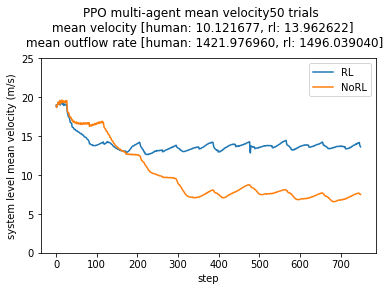

In [8]:
vel_fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(vel_mean)
ax.plot(human_vel_mean)
title = AGENT + ' multi-agent mean velocity'+str(num_trials)+' trials'
title = title + ' \n mean velocity [human: {:3f}, rl: {:3f}]'.format(np.mean(human_vel_mean), np.mean(vel_mean))
title = title + ' \n mean outflow rate [human: {:3f}, rl: {:3f}]'.format(np.mean(human_outflow_mean), np.mean(outflow_mean))
ax.set_ylim((0, 25))
ax.set_ylabel('system level mean velocity (m/s)')
ax.set_xlabel('step')
ax.legend(['RL', 'NoRL'])
vel_fig.suptitle(title)
plt.subplots_adjust(top=0.8)

Text(0.5, 0.98, 'PPO multi-agent mean outflow 50trials')

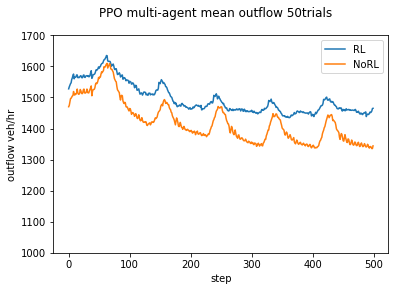

In [18]:
outflow_fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(outflow_mean)
ax.plot(human_outflow_mean)
title = AGENT + ' multi-agent mean outflow '+ str(num_trials) +'trials'
ax.set_ylabel('outflow veh/hr')
ax.set_xlabel('step')
ax.set_ylim([1000, 1700])
ax.legend(['RL', 'NoRL'])
outflow_fig.suptitle(title)
#plt.subplots_adjust(top=0.8)

(pid=37785) 2019-05-30 04:01:23,838	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 9 on CPU (please ignore any CUDA init errors)
(pid=37802) Closing connection to TraCI and stopping simulation.
(pid=37802) Note, this may print an error message when it closes.
(pid=37802) Closing connection to TraCI and stopping simulation.
(pid=37802) Note, this may print an error message when it closes.
(pid=37802) Closing connection to TraCI and stopping simulation.
(pid=37802) Note, this may print an error message when it closes.
(pid=37785) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=37785)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=37838) Closing connection to TraCI and stopping simulation.
(pid=37838) Note, this may print an error message when it closes.
(pid=3

(pid=45026) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=45026)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=44849) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=44849)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=44817) 2019-05-30 04:01:35,933	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 18 on CPU (please ignore any CUDA init errors)
(pid=44817) 2019-05-30 04:01:35.936309: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=44834) L

2019-05-30 04:01:45,714	WARNING worker.py:1569 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.
2019-05-30 04:01:45,781	WARNING worker.py:1569 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.
2019-05-30 04:01:45,828	WARNING worker.py:1569 -- The driver may not be able to keep up with the stdout/stderr of the workers. To avoid forwarding logs to the driver, use 'ray.init(log_to_driver=False)'.



(pid=44827) Success.
(pid=44828) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=44828)   "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
(pid=44980) 2019-05-30 04:01:38,261	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 14 on CPU (please ignore any CUDA init errors)
(pid=44827) Loading configuration... done.
(pid=44980) 2019-05-30 04:01:38.264099: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=44824) Loading configuration... done.
(pid=37799) Loading configuration... done.
(pid=44824) Success.
(pid=37799) Success.
(pid=48765) Closing connection to TraCI and stopping simulation.
(pid=48765) Note, this may print an error message when it closes.
(pid=44792)

(pid=44825) Closing connection to TraCI and stopping simulation.
(pid=44825) Note, this may print an error message when it closes.
(pid=44819) Closing connection to TraCI and stopping simulation.
(pid=44819) Note, this may print an error message when it closes.
(pid=48856) Closing connection to TraCI and stopping simulation.
(pid=48856) Note, this may print an error message when it closes.
(pid=44809) Closing connection to TraCI and stopping simulation.
(pid=44809) Note, this may print an error message when it closes.
(pid=44824) Closing connection to TraCI and stopping simulation.
(pid=44824) Note, this may print an error message when it closes.
(pid=44832) Closing connection to TraCI and stopping simulation.
(pid=44832) Note, this may print an error message when it closes.
(pid=48772) Closing connection to TraCI and stopping simulation.
(pid=48772) Note, this may print an error message when it closes.
(pid=44840) Closing connection to TraCI and stopping simulation.
(pid=44840) Note, 

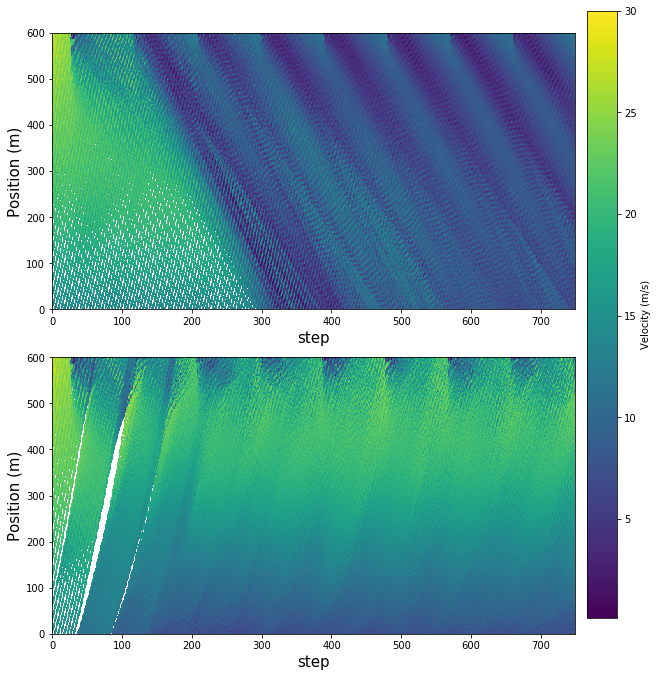

In [10]:
space_fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
space_fig.tight_layout(pad=3.0)

x = np.arange(int(env.env_params.horizon))
y = np.arange(0, int(left_length), step=0.1)
xx, yy = np.meshgrid(x, y)

# No RL
im = axes[0].pcolormesh(xx, yy, human_vel_map_mean.T)
axes[0].set_ylabel('Position (m)', fontsize=15.0)
axes[0].set_xlabel('step', fontsize=15.0)

# RL
im = axes[1].pcolormesh(xx, yy, vel_map_mean.T)
axes[1].set_ylabel('Position (m)', fontsize=15.0)
axes[1].set_xlabel('step', fontsize=15.0)

clb = space_fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
clb.set_clim(0, 30)
clb.set_label('Velocity (m/s)')
title = AGENT + ' Space-Time Diagram of 600 meter merge road'
# space_fig.suptitle(title)   
plt.subplots_adjust(top=0.9, right=0.8)

In [11]:
result_path = "/headless/rl_project/flow_codes/result/"

vel_filename = 'compare_trained_human_vel_'+str(num_trials)+'.png'
outflow_filename = 'compare_trained_human_outflow_'+str(num_trials)+'.png'
congestion_filename = 'compare_trained_human_congestion_'+str(num_trials)+'.png'
dir_path = result_path + 'MultiMerge/' + AGENT + '/' + exp_name + '/'+str(num_trials)+'/'
os.makedirs(dir_path, exist_ok=True)
vel_fig.savefig(dir_path + vel_filename)
outflow_fig.savefig(dir_path + outflow_filename)
space_fig.savefig(dir_path + congestion_filename)

In [12]:
agent = PPOAgent(config=config, env=env_name)
agent.restore(checkpoint_path)

2019-05-30 04:18:48,949	WARNING __init__.py:21 -- DeprecationWarning: PPOAgent has been renamed to PPOTrainer. This will raise an error in the future.
2019-05-30 04:18:48,969	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2019-05-30 04:18:48,970	WARNING ppo.py:171 -- FYI: By default, the value function will not share layers with the policy model ('vf_share_layers': False).
2019-05-30 04:18:50,207	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
/opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
2019-05-30 04:18:51,989	INFO policy_evaluator.py:728 -- Buil

(pid=59859) Loading configuration... done.
(pid=59859) Success.
(pid=59841) Loading configuration... done.
(pid=59841) Success.
(pid=59841) Loading configuration... done.
(pid=59866) Loading configuration... done.
(pid=59866) Success.
(pid=59866) Loading configuration... done.
(pid=59850) Loading configuration... done.
(pid=59850) Success.
(pid=59850) Loading configuration... done.
(pid=59867) Loading configuration... done.
(pid=59867) Success.
(pid=59867) Loading configuration... done.
(pid=59845) Loading configuration... done.
(pid=59845) Success.
(pid=59845) Loading configuration... done.
(pid=59832) Loading configuration... done.
(pid=59832) Success.
(pid=59832) Loading configuration... done.
(pid=59839) Loading configuration... done.
(pid=59839) Success.
(pid=59839) Loading configuration... done.
(pid=59846) Loading configuration... done.
(pid=59864) Loading configuration... done.
(pid=59864) Success.
(pid=59864) Loading configuration... done.
(pid=62261) Loading configuration... 

(pid=59861) 2019-05-30 04:18:54,712	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 19 on CPU (please ignore any CUDA init errors)
(pid=59861) 2019-05-30 04:18:54.714670: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=59842) 2019-05-30 04:18:54,663	INFO policy_evaluator.py:311 -- Creating policy evaluation worker 18 on CPU (please ignore any CUDA init errors)
(pid=59842) 2019-05-30 04:18:54.665890: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
(pid=59834) /opt/conda/envs/flow-latest/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
(pid=59834)   "Converting sparse IndexedSlices to a dense Tensor of unknown s

In [16]:
with open('best.wgt', 'wb') as f:
    weights = agent.get_weights()
    pickle.dump(weights, f)